In [1]:
import pandas as pd
import numpy as np


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve


In [5]:
data = pd.read_csv("C:/Aviii/Data_Sets/fraud_detection.csv")
data.head()


,transaction_id,amount,merchant_type,device_type,label
0,1,46.93,travel,tablet,0
1,2,301.01,groceries,desktop,0
2,3,131.67,others,tablet,0
3,4,91.29,electronics,desktop,0
4,5,16.96,others,mobile,0


In [6]:
print(data.columns.tolist())
print(data.info())
print(data.isnull().sum())


['transaction_id', 'amount', 'merchant_type', 'device_type', 'label']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  1000 non-null   int64  
 1   amount          1000 non-null   float64
 2   merchant_type   1000 non-null   object 
 3   device_type     1000 non-null   object 
 4   label           1000 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 39.2+ KB
None
transaction_id    0
amount            0
merchant_type     0
device_type       0
label             0
dtype: int64


In [7]:
data.columns = data.columns.str.strip().str.lower()
print(data.columns.tolist())


['transaction_id', 'amount', 'merchant_type', 'device_type', 'label']


In [8]:
if 'amount' in data.columns:
    data['amount'].fillna(data['amount'].median(), inplace=True)
if 'type' in data.columns:
    data['type'].fillna(data['type'].mode()[0], inplace=True)


In [9]:
if 'type' in data.columns:
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    type_encoded = encoder.fit_transform(data[['type']])
    type_encoded_df = pd.DataFrame(type_encoded, columns=encoder.get_feature_names_out(['type']), index=data.index)
    data = pd.concat([data.drop('type', axis=1), type_encoded_df], axis=1)


In [10]:
if 'amount' in data.columns:
    data['log_amount'] = np.log1p(data['amount'])


In [11]:
if 'amount' in data.columns:
    data['high_amount'] = (data['amount'] > data['amount'].median()).astype(int)


In [12]:
if 'transaction id' in data.columns:
    transaction_freq = data['transaction id'].value_counts().to_dict()
    data['transaction_freq'] = data['transaction id'].map(transaction_freq)


In [18]:
print(data.columns)

# Features (X) exclude transaction_id and label
X = data.drop(['transaction_id', 'label'], axis=1)

# Target (y) is the 'label' column
y = data['label']

print(X.head())
print(y.head())


Index(['transaction_id', 'amount', 'merchant_type', 'device_type', 'label',
       'log_amount', 'high_amount'],
      dtype='object')
   amount merchant_type device_type  log_amount  high_amount
0   46.93        travel      tablet    3.869742            0
1  301.01     groceries     desktop    5.710460            1
2  131.67        others      tablet    4.887865            1
3   91.29   electronics     desktop    4.524936            1
4   16.96        others      mobile    2.888147            0
0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [23]:
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
import pandas as pd

# Encode categorical columns before SMOTE
categorical_cols = ['merchant_type', 'device_type']  # your categorical columns in X_train

# One-hot encode
encoder = OneHotEncoder(drop='first', sparse_output=False)  # changed from sparse=False
encoded_features = encoder.fit_transform(X_train[categorical_cols])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols), index=X_train.index)

# Combine with numeric features
X_train_numeric = pd.concat([X_train.drop(categorical_cols, axis=1), encoded_df], axis=1)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_numeric, y_train)

# Check shapes
print("Resampled X_train shape:", X_train_res.shape)
print("Resampled y_train shape:", y_train_res.shape)


Resampled X_train shape: (1330, 9)
Resampled y_train shape: (1330,)


Best Parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       285
           1       0.00      0.00      0.00        15

    accuracy                           0.90       300
   macro avg       0.47      0.48      0.47       300
weighted avg       0.90      0.90      0.90       300

Confusion Matrix:
 [[271  14]
 [ 15   0]]
ROC-AUC: 0.4738011695906433


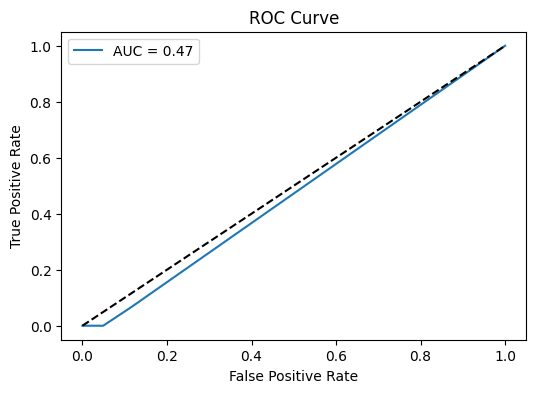

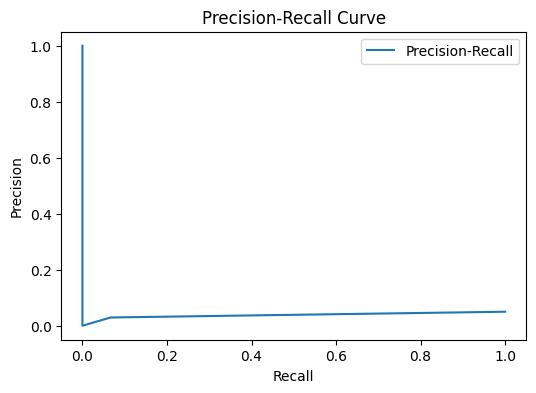

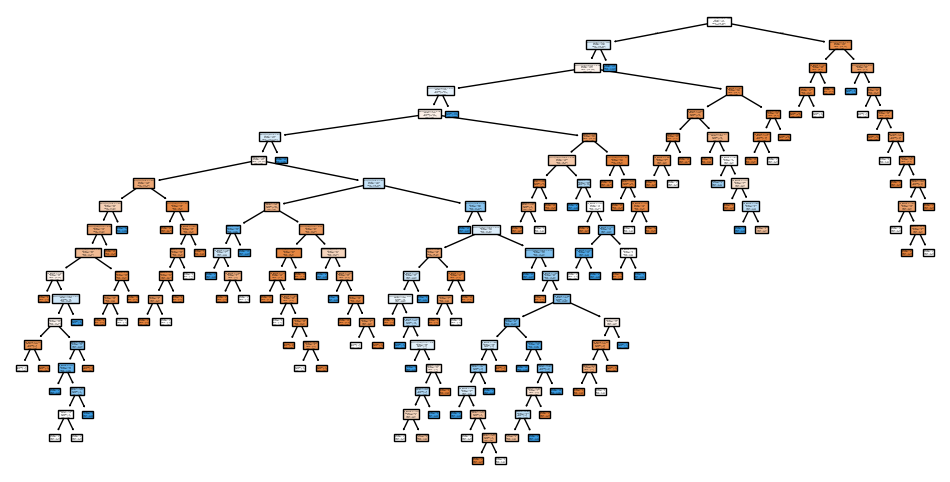

NameError: name 'joblib' is not defined

In [24]:
# 1. Update X_train and X_test with encoded features
X_train_encoded = X_train.drop(categorical_cols, axis=1)
X_train_encoded = pd.concat([X_train_encoded, encoded_df], axis=1)

X_test_encoded = X_test.drop(categorical_cols, axis=1)
encoded_test_features = encoder.transform(X_test[categorical_cols])
encoded_test_df = pd.DataFrame(encoded_test_features, columns=encoder.get_feature_names_out(categorical_cols), index=X_test.index)
X_test_encoded = pd.concat([X_test_encoded, encoded_test_df], axis=1)

# 2. Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_encoded, y_train)

# 3. Hyperparameter tuning with GridSearchCV
param_grid = {
    'criterion': ['gini','entropy'],
    'max_depth': [3,5,10,None],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
    'class_weight': [None, 'balanced']
}

grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=StratifiedKFold(n_splits=5),
    scoring='f1',
    n_jobs=-1
)

grid.fit(X_train_res, y_train_res)

best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

# 4. Evaluate Model
y_pred = best_model.predict(X_test_encoded)
y_prob = best_model.predict_proba(X_test_encoded)[:,1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

# 5. Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# 6. Plot Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(6,4))
plt.plot(rec, prec, label="Precision-Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# 7. Visualize Decision Tree (optional)
plt.figure(figsize=(12,6))
plot_tree(best_model, feature_names=X_train_encoded.columns, class_names=["Legit","Fraud"], filled=True)
plt.show()

# 8. Save the model
joblib.dump(best_model, "fraud_detection_model.pkl")
print("Model saved as fraud_detection_model.pkl")


In [26]:
#Update X_train and X_test with encoded features
X_train_encoded = X_train.drop(categorical_cols, axis=1)
X_train_encoded = pd.concat([X_train_encoded, encoded_df], axis=1)

X_test_encoded = X_test.drop(categorical_cols, axis=1)
encoded_test_features = encoder.transform(X_test[categorical_cols])
encoded_test_df = pd.DataFrame(encoded_test_features, columns=encoder.get_feature_names_out(categorical_cols), index=X_test.index)
X_test_encoded = pd.concat([X_test_encoded, encoded_test_df], axis=1)



In [27]:
#Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_encoded, y_train)




In [28]:
#  Hyperparameter tuning with GridSearchCV
param_grid = {
    'criterion': ['gini','entropy'],
    'max_depth': [3,5,10,None],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
    'class_weight': [None, 'balanced']
}

grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=StratifiedKFold(n_splits=5),
    scoring='f1',
    n_jobs=-1
)

grid.fit(X_train_res, y_train_res)

best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)



Best Parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [29]:
# Evaluate Model
y_pred = best_model.predict(X_test_encoded)
y_prob = best_model.predict_proba(X_test_encoded)[:,1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))



Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       285
           1       0.00      0.00      0.00        15

    accuracy                           0.90       300
   macro avg       0.47      0.48      0.47       300
weighted avg       0.90      0.90      0.90       300

Confusion Matrix:
 [[271  14]
 [ 15   0]]
ROC-AUC: 0.4738011695906433


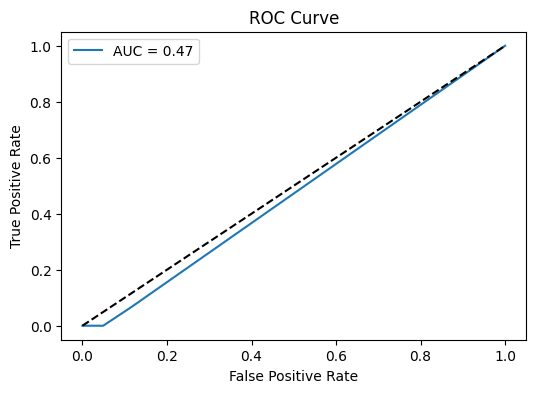

In [30]:

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


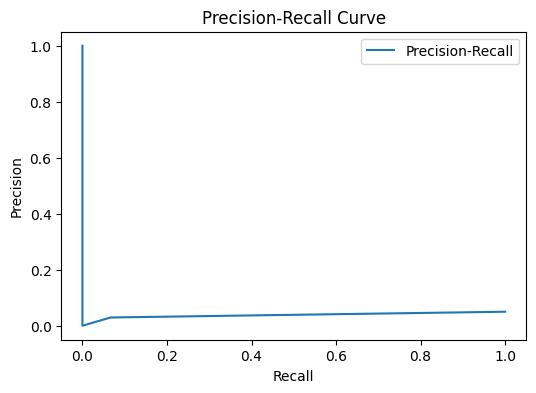

In [31]:

# Plot Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(6,4))
plt.plot(rec, prec, label="Precision-Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()



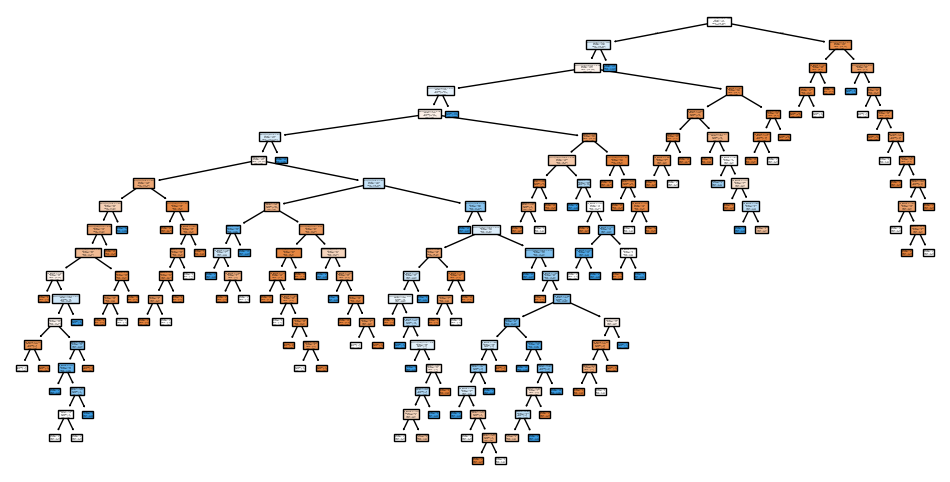

In [32]:
# Visualize Decision Tree (optional)
plt.figure(figsize=(12,6))
plot_tree(best_model, feature_names=X_train_encoded.columns, class_names=["Legit","Fraud"], filled=True)
plt.show()



In [34]:
!pip install joblib


In [35]:
import joblib


In [36]:
# 8. Save the model
joblib.dump(best_model, "fraud_detection_model.pkl")
print("Model saved as fraud_detection_model.pkl")

Model saved as fraud_detection_model.pkl
